In [1]:
# Import libraries
import awswrangler as wr
import numpy as np
import pandas as pd

from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np
from sklearn.metrics import mean_absolute_error
print(tf.__version__)


2.7.0


In [2]:
dataset = 'feature_extract'

In [3]:
# Read in small dataset
meth = pd.read_csv('Endometriosis_subset_train_feature_extract.csv')

In [4]:
# Set axis to IDs
meth.set_axis(meth['meth_id'], inplace = True)

In [5]:
# Drop the ID cols 
cols_drop = ['meth_id', 'meth_id.1']
meth.drop(columns=cols_drop, inplace = True)

In [6]:
# Change Endo Yes/No to binary
meth['Endometriosis_int'] = np.where(meth['Endometriosis'] == 'Yes', 1, meth['Endometriosis'])
meth['Endometriosis_int'] = np.where(meth['Endometriosis_int'] == 'No', 0, meth['Endometriosis_int'])

In [7]:
# Split dataset into features and target 
#y_train = meth['Endometriosis_int']
#x_train = meth.iloc[:, 5:-1]

In [8]:
# Comment out to remove Cycle Phase from features
meth = meth.join(pd.get_dummies(meth['Cycle_Phase']))
y_train = meth.pop('Endometriosis_int')
x_train = meth.iloc[:, 5:]

In [9]:
val = pd.read_csv('Endometriosis_subset_test_feature_extract.csv')

In [10]:
val = val.set_axis(val['meth_id'])

In [11]:
# Group ESE, MSE and LSE into SE 
val.loc[val['Cycle_Phase'].isin(['ESE', 'MSE', 'LSE']), 'Cycle_Phase'] = 'SE'

In [12]:
# Split dataset into features and target 
#x_val = val.iloc[:, 6:-1]
#y_val = val['Endometriosis_int']

In [13]:
# Comment out to remove Cycle Phase from features
val = val.join(pd.get_dummies(val['Cycle_Phase']))
y_val = val.pop('Endometriosis_int')
x_val = val.iloc[:, 6:]

In [14]:
test2 = pd.read_csv('Endometriosis_subset_test2_feature_extract.csv')

In [15]:
test2.set_index('meth_id', inplace = True)

In [16]:
#x_test2 = test2.iloc[:, 5:-1]
#y_test2 = test2['Endometriosis_int']

In [17]:
# Comment out to remove Cycle Phase from features
test2 = test2.join(pd.get_dummies(test2['Cycle_Phase']))
y_test2 = test2.pop('Endometriosis_int')
x_test2 = test2.iloc[:, 5:]

In [18]:
print(x_train.shape, x_val.shape, x_test2.shape)

(793, 45191) (199, 45191) (52, 45191)


In [19]:
print(y_train.shape, y_val.shape, y_test2.shape)

(793,) (199,) (52,)


In [20]:
x_train_df = x_train
x_val_df = x_val

In [21]:
feature_names = x_train.columns

In [22]:
import pandas as pd 
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import r2_score
import itertools 
from itertools import chain
from sklearn.model_selection import train_test_split
import scipy 
from scipy.stats import linregress

activation1 = 'relu'
activation2 = 'relu'
nodes = 500

    
# Convert to float32
x_train = np.asarray(x_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
x_val = np.asarray(x_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')
x_test2 = np.asarray(x_test2).astype('float32')
y_test2 = np.asarray(y_test2).astype('float32')


# build model
model = Sequential()
model.add(Dense(nodes, input_dim=x_train.shape[1], activation = activation1))
model.add(Dense(nodes, activation= activation1))
model.add(Dense(nodes, activation=activation1))
model.add(Dense(nodes, activation=activation1))
model.add(Dense(nodes, activation=activation1))
model.add(Dense(nodes, activation=activation1))
model.add(Dense(nodes, activation=activation1))
model.add(Dense(nodes, activation=activation1))
model.add(Dense(nodes, activation=activation2))
model.add(Dense(1))
model.compile(loss='mae', optimizer=tf.optimizers.Adamax(0.0001), metrics=['mae'])

class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')

# Training
history = model.fit(x_train,y_train, validation_data=(x_val,y_val),verbose=0,
      epochs=500, callbacks = [PrintDot()])

train_pred = model.predict(x_train)

# val Prediction
pred = model.predict(x_val)

# External Test Prediction
pred_ext = model.predict(x_test2)


# Measure this fold's MAE
train_score = np.sqrt(metrics.mean_absolute_error(train_pred, y_train))
#R2_train = r2_score(train_pred, y_train)
r_val = np.corrcoef(train_pred.flatten(), y_train.flatten())
R2_train = str(r_val[0, 1]**2)
print(f"Train score (R2): {R2_train}")
print(f"Train score (MAE): {train_score}")


score = np.sqrt(metrics.mean_absolute_error(pred,y_val))
#R2 = r2_score(pred, y_val)
r_val = np.corrcoef(pred.flatten(), y_val.flatten())
R2 = str(r_val[0, 1]**2)
print(f"Val score (R2): {R2}")
print(f"Val score (MAE): {score}")
    
    
score = np.sqrt(metrics.mean_absolute_error(pred_ext,y_test2))
#R2 = r2_score(pred, y_test)
r_val = np.corrcoef(pred_ext.flatten(), y_test2.flatten())
R2 = str(r_val[0, 1]**2)
print(f"External Test score (R2): {R2}")
print(f"External Test score (MAE): {score}")


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................Train score (R2): 0.9996366459768204
Train score (MAE): 0.13467563688755035
Val score (R2): 0.1728459447723525
Val score (MAE): 0.5954668521881104
External Test score (R2): 0.16029509208921647
External Test score (MAE): 0.5942586660385132


In [23]:
score = np.sqrt(metrics.mean_absolute_error(pred_ext,y_test2))

In [24]:
train_pred = train_pred.flatten()

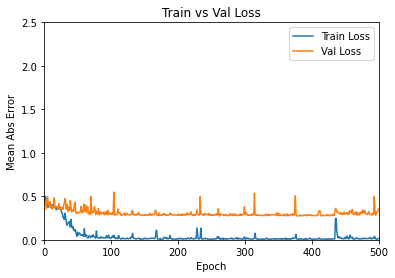

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot()
ax.plot(history.epoch, np.array(history.history['mae']),
           label='Train Loss')
ax.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.title('Train vs Val Loss')
plt.legend()
plt.ylim([0, 2.5])
plt.xlim([0, 500])
plt.show()
fig.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'train_loss_' + '.png', dpi=400, bbox_inches = "tight")


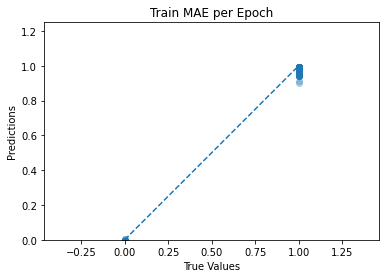

In [26]:
plt.scatter(y_train, train_pred, alpha = 0.3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.title('Train MAE per Epoch')
plt.xlim(0, 1)
plt.ylim(0, 1.25)
plt.plot([0, 1], [0,1], '--')
plt.savefig(dataset + '_' +activation1 + '_' + activation2 + '_' + 'true_vs_pred_train.png', bbox_inches = "tight")

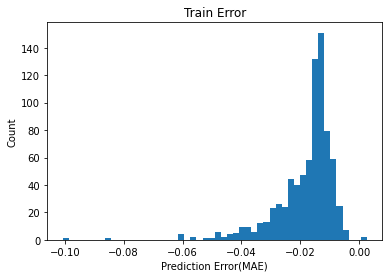

In [27]:
error = train_pred - y_train
plt.hist(error, bins = 50)
plt.title('Train Error')
plt.xlabel("Prediction Error(MAE)")
_ = plt.ylabel("Count")
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'train_error.png', bbox_inches = "tight")

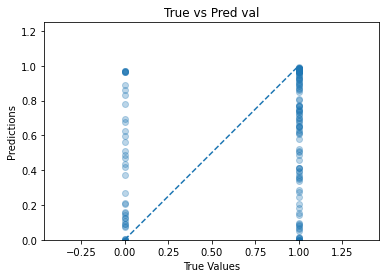

In [28]:
plt.scatter(y_val, pred, alpha = 0.3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.title('True vs Pred val')
plt.xlim(0, 1)
plt.ylim(0, 1.25)
plt.plot([0, 1], [0,1], '--')
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'true_vs_pred_val.png', bbox_inches = "tight")

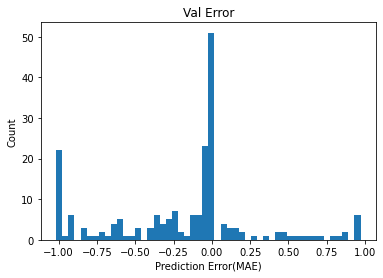

In [29]:
error = pred.flatten() - y_val.flatten()
plt.hist(error, bins = 50)
plt.title('Val Error')
plt.xlabel("Prediction Error(MAE)")
_ = plt.ylabel("Count")
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'val_error.png', bbox_inches = "tight")

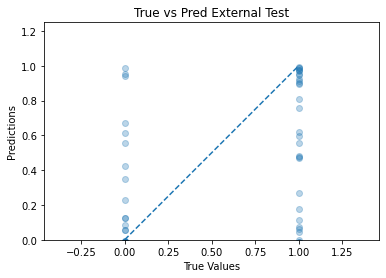

In [30]:
plt.scatter(y_test2.flatten(), pred_ext.flatten(), alpha = 0.3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.title('True vs Pred External Test')
plt.xlim(0, 1)
plt.ylim(0, 1.25)
plt.plot([0, 1], [0,1], '--')
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'true_vs_pred_external_test.png', bbox_inches = "tight")

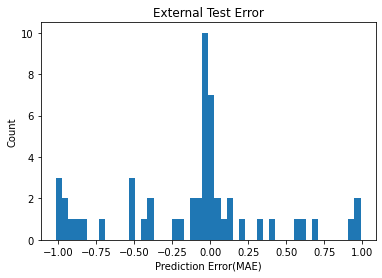

In [31]:
error = pred_ext.flatten() - y_test2.flatten()
plt.hist(error, bins = 50)
plt.title('External Test Error')
plt.xlabel("Prediction Error(MAE)")
_ = plt.ylabel("Count")
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'external_test_error.png', bbox_inches = "tight")

In [32]:
r_probs = [0 for _ in range(len(y_val))]

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score
#Random chance ROC
r_auc = roc_auc_score(y_val, r_probs)
r_fpr, r_tpr, _ = roc_curve(y_val, r_probs)

#val ROC
fpr, tpr, _ = roc_curve(y_val, pred)
auc = roc_auc_score(y_val, pred)

#Train ROC
tr_fpr, tr_tpr, _ = roc_curve(y_train, train_pred)
tr_auc = roc_auc_score(y_train, train_pred)

# External Test ROC
ext_fpr, ext_tpr, _ = roc_curve(y_test2, pred_ext)
ext_auc = roc_auc_score(y_test2, pred_ext)

In [34]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Val Prediction: AUROC = %.3f' % (auc))
print('Train Prediction: AUROC = %.3f' % (tr_auc))
print('External Test Prediction: AUROC = %.3f' % (ext_auc))

Random (chance) Prediction: AUROC = 0.500
Val Prediction: AUROC = 0.761
Train Prediction: AUROC = 1.000
External Test Prediction: AUROC = 0.729


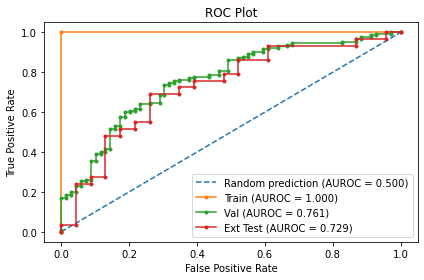

In [35]:
# AUC Plot
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(tr_fpr, tr_tpr, marker='.', label='Train (AUROC = %0.3f)' % tr_auc)
plt.plot(fpr, tpr, marker='.', label='Val (AUROC = %0.3f)' % auc)
plt.plot(ext_fpr, ext_tpr, marker='.', label='Ext Test (AUROC = %0.3f)' % ext_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend(loc = 'lower right', prop={'size': 10}) 
plt.tight_layout()
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'ROC_Curve' + '.png', bbox_inches = "tight")

In [36]:
val_pred_int = np.where(pred<0.5, 0, 1)
train_pred_int = np.where(train_pred<0.5, 0, 1)
ext_test_pred_int = np.where(pred_ext<0.5, 0, 1)

In [37]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
val_conf = confusion_matrix(y_val, val_pred_int)
train_conf = confusion_matrix(y_train, train_pred_int)
ext_test_conf = confusion_matrix(y_test2, ext_test_pred_int)

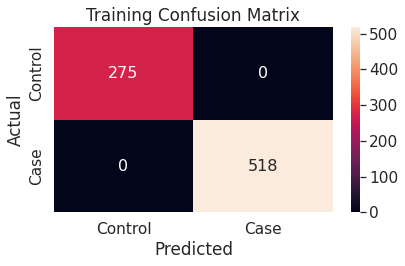

In [38]:
# Plot Confusion Matrices 
import seaborn as sns
df_cm = pd.DataFrame(train_conf, range(2), range(2))
df_cm = df_cm.rename(index={0: "Control", 1: "Case"})
df_cm = df_cm.rename(columns={0: "Control", 1: "Case"})
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Training Confusion Matrix')
plt.tight_layout()
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'confusion_matrix_train' + '.png', bbox_inches = "tight")

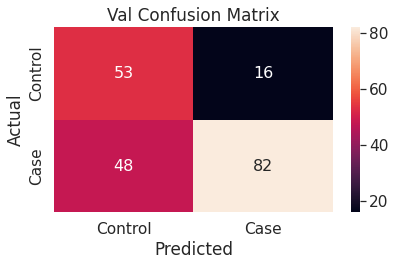

In [39]:
import seaborn as sns
df_cm = pd.DataFrame(val_conf, range(2), range(2))
df_cm = df_cm.rename(index={0: "Control", 1: "Case"})
df_cm = df_cm.rename(columns={0: "Control", 1: "Case"})
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Val Confusion Matrix')
plt.tight_layout()
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'confusion_matrix_val' + '.png', bbox_inches = "tight")

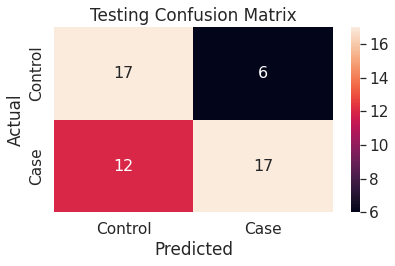

In [40]:
df_cm = pd.DataFrame(ext_test_conf, range(2), range(2))
df_cm = df_cm.rename(index={0: "Control", 1: "Case"})
df_cm = df_cm.rename(columns={0: "Control", 1: "Case"})
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Testing Confusion Matrix')
plt.tight_layout()
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'confusion_matrix_external_test' + '.png', bbox_inches = "tight")

In [41]:
# Define AUC metric function
def get_auc(val_auc, train_auc):
    auc_score = roc_auc_score(val_auc, train_auc)
    return auc_score

In [42]:
from mlxtend.evaluate import feature_importance_permutation

In [43]:
# feature importance permutation 
imp_vals, imp_all = feature_importance_permutation(
    predict_method = model.predict,
    X = x_test2,
    y = y_test2,
    metric =  get_auc,
    num_rounds = 1)

In [46]:
# sort the cpg islands from descending order of importance 
indices = np.argsort(imp_vals)[::-1]

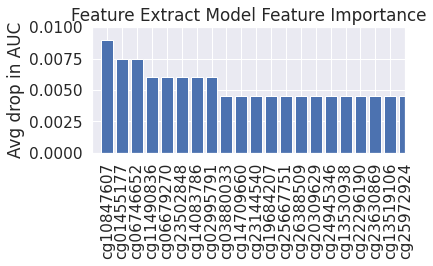

In [49]:
# plot top 20 cpg islands 
plt.figure()
plt.title("Feature Extract Model Feature Importance")
plt.ylabel('Avg drop in AUC')
plt.bar(range(x_train.shape[1]), imp_vals[indices])

plt.xticks(range(x_train.shape[1]), x_train_df.columns[indices], rotation=90)
plt.xlim([-1, 20])
plt.ylim([0, 0.01])

plt.tight_layout()
plt.savefig('Feature Importance.png')
plt.show()

In [50]:
# Get top 50 CPG islands
cpg_islands = x_train_df.columns[indices][:50]

In [51]:
# export top 50 cpg islands
with open("top_50_cpg_islands.txt","w") as f:
    for line in cpg_islands:
        f.write(line)
        f.write("\n")

In [52]:
cpg_islands_500 = x_train_df.columns[indices][:500]

In [53]:
with open("top_500_cpg_islands.txt","w") as f:
    for line in cpg_islands_500:
        f.write(line)
        f.write("\n")

In [55]:
top_500 = x_train_df.columns[indices][:500]

In [56]:
top_500_df = x_train_df.loc[:,top_500]

In [57]:
# concatenate train, val and external test datasets 
df = pd.concat([meth, val, test2])

In [58]:
# subset the top 500 cpgs from the full dataset above 
top_500_df = df.loc[:,top_500]

In [59]:
top_500_df

,cg10847607,cg01455177,cg06746652,cg11490836,cg06679270,cg23502848,cg14083786,cg02995791,cg03880033,cg14709660,...,cg13678371,cg14032572,cg07086736,cg22544881,cg17314228,cg15420678,cg17529006,cg17999327,cg00238023,cg00151191
meth_id,,,,,,,,,,,,,,,,,,,,,
202184900066_R02C01,0.355499,0.267554,0.198400,-0.067062,1.194292,-1.595121,0.057838,0.663615,0.803006,2.450953,...,-3.930064,-3.289862,2.582005,-0.330857,0.106963,-0.275439,3.018634,-0.261355,2.401096,2.084982
201980430023_R03C01,-0.424507,-0.387429,2.306855,0.001287,1.266872,-3.330437,-0.322860,-0.829771,0.216201,1.886796,...,-3.970000,-3.477764,2.648937,-0.375327,-0.073459,-0.057028,3.267005,-0.174578,2.781688,1.776822
202875000120_R08C01,1.325579,-0.334949,0.660044,-0.206156,2.409493,-2.975124,-0.173542,2.263811,-1.538416,2.823336,...,-3.889118,-2.463245,2.653499,-0.569439,-0.072968,-0.038259,3.071271,-0.168776,2.890813,1.927704
202875000094_R02C01,-0.558004,-0.273080,-0.214115,0.183017,1.124982,-0.571336,-0.077889,2.566051,0.194985,2.654295,...,-4.075801,-3.583857,2.394742,-0.594309,-0.016701,-0.135667,3.584026,-0.317135,3.525864,1.676399
202878330076_R08C01,-1.054382,0.526308,1.455752,-0.547322,0.941811,-0.195491,0.225557,1.279837,0.963979,2.276844,...,-4.352260,-3.719521,2.384211,-0.517304,-0.180730,-0.175286,3.549191,-0.739583,3.700551,1.963013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202176300029_R05C01,1.275044,-0.098131,0.559857,0.938766,1.641099,-2.594446,1.184224,-0.981177,0.117590,3.013985,...,-4.017658,-3.287695,2.985043,-0.408804,-0.064607,-0.078830,3.233064,-0.337092,4.093072,2.087463
202875000117_R05C01,0.740626,-0.403682,-0.099276,-0.121550,1.004861,-2.451490,-0.387013,0.258035,0.192889,2.526099,...,-4.341832,-3.488023,3.535711,-0.505766,-0.028004,-0.051533,3.044067,-0.958960,3.305501,1.653547
202184900024_R04C01,1.027240,0.219683,0.964896,0.304445,1.725348,-2.746075,-0.625839,0.557543,0.334704,2.474669,...,-3.714420,-2.912720,3.211687,-0.427836,-0.217012,-0.299361,2.706499,-0.330090,2.745721,1.635396
